<a href="https://colab.research.google.com/github/vaniseth/Federated-Learning/blob/main/Federate_FedProx_Keras_MNIST_model_using_OpenFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 438 kB 67.3 MB/s 
     |████████████████████████████████| 1.6 MB 55.7 MB/s 
     |████████████████████████████████| 5.8 MB 53.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

Loading the mnist dataset and other dependencies.

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [3]:
!pip install openfl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 535 kB 4.0 MB/s 
     |████████████████████████████████| 4.0 MB 55.5 MB/s 
     |████████████████████████████████| 125 kB 66.7 MB/s 
     |████████████████████████████████| 8.8 MB 50.0 MB/s 
     |████████████████████████████████| 161 kB 70.7 MB/s 
     |████████████████████████████████| 2.5 MB 33.8 MB/s 
     |████████████████████████████████| 146 kB 55.9 MB/s 
     |████████████████████████████████| 596 kB 69.9 MB/s 
     |████████████████████████████████| 200 kB 75.9 MB/s 
     |████████████████████████████████| 4.1 MB 29.4 MB/s 
     |████████████████████████████████| 97 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 344 kB 58.7 MB/s 
     |████████████████████████████████| 9.7 MB 34.4 MB/s 
     |████████████████████████████████

In [4]:
import openfl.native as fx
from openfl.federated import FederatedModel,FederatedDataSet
tf.config.run_functions_eagerly(True)
tf.random.set_seed(0)
np.random.seed(0)

In [5]:
!pip install intel-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 232.6 MB 59 kB/s 


In [6]:
def test_intel_tensorflow():
    """
    Check if Intel version of TensorFlow is installed
    """
    import tensorflow as tf

    print("We are using Tensorflow version {}".format(tf.__version__))

    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
        from tensorflow.python.util import _pywrap_util_port
        print("Intel-optimizations (DNNL) enabled:",
              _pywrap_util_port.IsMklEnabled())
    else:
        print("Intel-optimizations (DNNL) enabled:")

test_intel_tensorflow()

We are using Tensorflow version 2.9.1
Intel-optimizations (DNNL) enabled: False


After importing the required packages, we then setup our openfl workspace. fx.init() command is used
to setup a deafult workspace.

In [7]:
#Setup default workspace, logging, etc.
fx.init('keras_cnn_mnist')

Creating Workspace Directories
Creating Workspace Templates

New workspace directory structure:
workspace
├── cert
├── save
├── data
├── requirements.txt
├── src
│   ├── __init__.py
│   ├── keras_cnn.py
│   ├── tfmnist_inmemory.py
│   └── mnist_utils.py
├── logs
├── .workspace
└── plan
    ├── cols.yaml
    ├── defaults
    ├── plan.yaml
    └── data.yaml

6 directories, 10 files
Setting Up Certificate Authority...

1.  Create Root CA
1.1 Create Directories
1.2 Create Database
1.3 Create CA Request and Certificate
2.  Create Signing Certificate
2.1 Create Directories
2.2 Create Database
2.3 Create Signing Certificate CSR
2.4 Sign Signing Certificate CSR
3   Create Certificate Chain

Done.
Creating AGGREGATOR certificate key pair with following settings: CN=844601cc789c, SAN=DNS:844601cc789c
  Writing AGGREGATOR certificate key pair to: /content/cert/server
The CSR Hash for file server/agg_844601cc789c.csr = 622ad14743b053d73a96b75c3b0515cb4c454d04e7138c6a37728e1ecb8e798eef2f2273dc09cdc

Now we are ready to define our datatset and model to perform federated learning on it. We will start with a fully connected model that is trained on the MNIST dataset.

In [8]:
#Import and process training, validation, and test images/labels

# Set the ratio of validation imgs, can't be 0.0
VALID_PERCENT = 0.3

(X_train, y_train), (X_test, y_test) = mnist.load_data()
split_on = int((1 - VALID_PERCENT) * len(X_train))

train_images = X_train[0:split_on,:,:]
train_labels = to_categorical(y_train)[0:split_on,:]

valid_images = X_train[split_on:,:,:]
valid_labels = to_categorical(y_train)[split_on:,:]

test_images = X_test
test_labels = to_categorical(y_test)

def preprocess(images):
    #Normalize
    images = (images / 255) - 0.5
    images = images.reshape(images.shape[0], -1)
#     images = np.expand_dims(images, axis=-1)
    return images

# Preprocess the images.
train_images = preprocess(train_images)
valid_images = preprocess(valid_images)
test_images = preprocess(test_images)

feature_shape = train_images.shape[1:]
classes = 10

class UnbalancedFederatedDataset(FederatedDataSet):
    def split(self, num_collaborators, shuffle=True, equally=False):
        train_idx = self.split_lognormal(self.y_train, num_collaborators)
        X_train = np.array([self.X_train[idx] for idx in train_idx])
        y_train = np.array([self.y_train[idx] for idx in train_idx])
        
        valid_idx = self.split_lognormal(self.y_valid, num_collaborators)
        X_valid = np.array([self.X_valid[idx] for idx in valid_idx])
        y_valid = np.array([self.y_valid[idx] for idx in valid_idx])
        
        return [
            FederatedDataSet(
                X_train[i],
                y_train[i],
                X_valid[i],
                y_valid[i],
                batch_size=self.batch_size,
                num_classes=self.num_classes
            ) for i in range(num_collaborators)
        ]
    
    def split_lognormal(self, labels, num_collaborators):
        from tqdm import trange
        labels = np.argmax(labels, axis=1)
        idx = [[np.nonzero(labels == (col + j) % self.num_classes)[0][np.arange(5) + (col // 10 * 10 + 5 * j)] \
            for j in range(2)] for col in range(num_collaborators)]
        idx = [np.hstack(tup) for tup in idx]
        assert all([len(i) == 10 for i in idx]), 'All collaborators should have 10 elements at this stage'
        props = np.random.lognormal(0, 2.0, (10,100,2))
        props = np.array([[[len(np.nonzero(labels==label)[0])-1000]] for label in range(10)])*props/np.sum(props,(1,2), keepdims=True)
        #idx = 1000*np.ones(10, dtype=np.int64)
        for user in trange(1000):
            for j in range(2):
                l = (user+j)%10
                num_samples = int(props[l,user//10,j])
                if np.count_nonzero(labels[np.hstack(idx)] == l) + num_samples < len(np.nonzero(labels==l)[0]):
                    idx_to_append = np.nonzero(labels == (user + j) % 10)[0][np.arange(num_samples) + np.count_nonzero(labels[np.hstack(idx)] == l)]
                    idx[user] = np.append(idx[user], idx_to_append)
        return idx

fl_data = UnbalancedFederatedDataset(train_images,train_labels,valid_images,valid_labels,batch_size=32,num_classes=classes)


11490434/11490434 [==============================] - 0s 0us/step


The code starts by iporting the MNIST dataset. It then loads the training, validation nad test images/labels into variables. It then sets up a ratio of validation images to train that is 0.3 or 30%

The code is meant to preprocess the images in order to normalize them. The code then takes these normalized images and reshapes them into a maxtrix of size (N,3) where N is the number of training images and 3 is the number of labels.

The code then creates a FedereatedDataSet class that will hold the data from both datasets. The split function is called on each of these datasets to create an array of objects for each class in the dataset.

The code uses a lognormal distribution function in order to generate random values that are used as labels in order to create a balanced dataset.

The code then creates a list of all the collaborators. A random normal distribution is created which is used to generate probabilities for each collaborator's probability for being selected as one of the top 10 collaborators.


```idx = [[np.nonzero(labels == (col + j) % self.num_classes)[0][np.arange(5) + (col // 10 * 10 + 5 * j)] \ for j in range(2)] for col in range(num_collaborators)] ```

The above code then creates an index that contains all the possible combinations of labels and indices for every collaborator based on their position within the collaboration network and how many classes they have been assigned so far. This way we can find out which collaborator is most likely to happen given certain conditions such as if there are only two people or three people involved in a collaboration etc.

In [9]:
from openfl.utilities.optimizers.keras import FedProxOptimizer

In [30]:
def build_model(input_shape,
                num_classes,
                **kwargs):
    """
    Define the model architecture.

    Args:
        input_shape (numpy.ndarray): The shape of the data
        num_classes (int): The number of classes of the dataset

    Returns:
        tensorflow.python.keras.engine.sequential.Sequential: The model defined in Keras

    """
    model = Sequential()
    
    model.add(tf.keras.Input(shape=input_shape))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=FedProxOptimizer(mu=1),
                  metrics=['accuracy'])

    return model   

The code is used to define a model architecture. It defines a sequential model with an input layer followed by a dense layer with num_classes as it's input dimension and a softmax activation function.

The loss function used it categorical_crissentropy, which takes two input i.e one for each class.

The optimzer used is FedProxOptimizer, which is ised to minimize the cross entropy between all pairs of classes

In [11]:
#Create a federated model using the build model function and dataset
fl_model = FederatedModel(build_model, data_loader=fl_data)

The FederatedModel object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with openfl. It provides built in federated training and validation functions that we will see used below. Using it's setup function, collaborator models and datasets can be automatically defined for the experiment.

In [12]:
collaborator_models = fl_model.setup(num_collaborators=1000)
 
collaborators = {f'col{col}':collaborator_models[col] for col in range(len(collaborator_models))}#, 'three':collaborator_models[2]}


100%|██████████| 1000/1000 [00:04<00:00, 226.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 1000/1000 [00:02<00:00, 419.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

In [23]:
#Original MNIST dataset
print(f'Original training data size: {len(train_images)}')
print(f'Original validation data size: {len(valid_images)}\n')

#Collaborator one's data
print(f'Collaborator one\'s training data size: {len(collaborator_models[0].data_loader.X_train)}')
print(f'Collaborator one\'s validation data size: {len(collaborator_models[0].data_loader.X_valid)}\n')

#Collaborator two's data
print(f'Collaborator two\'s training data size: {len(collaborator_models[1].data_loader.X_train)}')
print(f'Collaborator two\'s validation data size: {len(collaborator_models[1].data_loader.X_valid)}\n')

#Collaborator three's data
#print(f'Collaborator three\'s training data size: {len(collaborator_models[2].data_loader.X_train)}')
#print(f'Collaborator three\'s validation data size: {len(collaborator_models[2].data_loader.X_valid)}')


Original training data size: 42000
Original validation data size: 18000

Collaborator one's training data size: 86
Collaborator one's validation data size: 10

Collaborator two's training data size: 12
Collaborator two's validation data size: 10



We can see the current plan values by running the fx.get_plan() function

In [24]:
#Get the current values of the plan. Each of these can be overridden
import json
print(json.dumps(fx.get_plan(), indent=4, sort_keys=True))

"{\n    \"aggregator.settings.best_state_path\": \"save/keras_cnn_mnist_best.pbuf\",\n    \"aggregator.settings.db_store_rounds\": 2,\n    \"aggregator.settings.init_state_path\": \"save/keras_cnn_mnist_init.pbuf\",\n    \"aggregator.settings.last_state_path\": \"save/keras_cnn_mnist_last.pbuf\",\n    \"aggregator.settings.rounds_to_train\": 10,\n    \"aggregator.settings.write_logs\": false,\n    \"aggregator.template\": \"openfl.component.Aggregator\",\n    \"assigner.settings.task_groups\": [\n        {\n            \"name\": \"train_and_validate\",\n            \"percentage\": 1.0,\n            \"tasks\": [\n                \"aggregated_model_validation\",\n                \"train\",\n                \"locally_tuned_model_validation\"\n            ]\n        }\n    ],\n    \"assigner.template\": \"openfl.component.RandomGroupedAssigner\",\n    \"collaborator.settings.db_store_rounds\": 1,\n    \"collaborator.settings.delta_updates\": false,\n    \"collaborator.settings.opt_treatmen

Now we are ready to run our experiment. If we want to pass in custom plan settings, we can easily do that with the override_config parameter

In [ ]:
#Run experiment, return trained FederatedModel
final_fl_model = fx.run_experiment(collaborators,override_config={'aggregator.settings.rounds_to_train':5, 'collaborator.settings.opt_treatment': 'CONTINUE_GLOBAL'})


In [ ]:
#Save final model and load into keras
final_fl_model.save_native('final_model')
model = tf.keras.models.load_model('./final_model')

In [ ]:
#Test the final model on our test set
model.evaluate(test_images,test_labels)

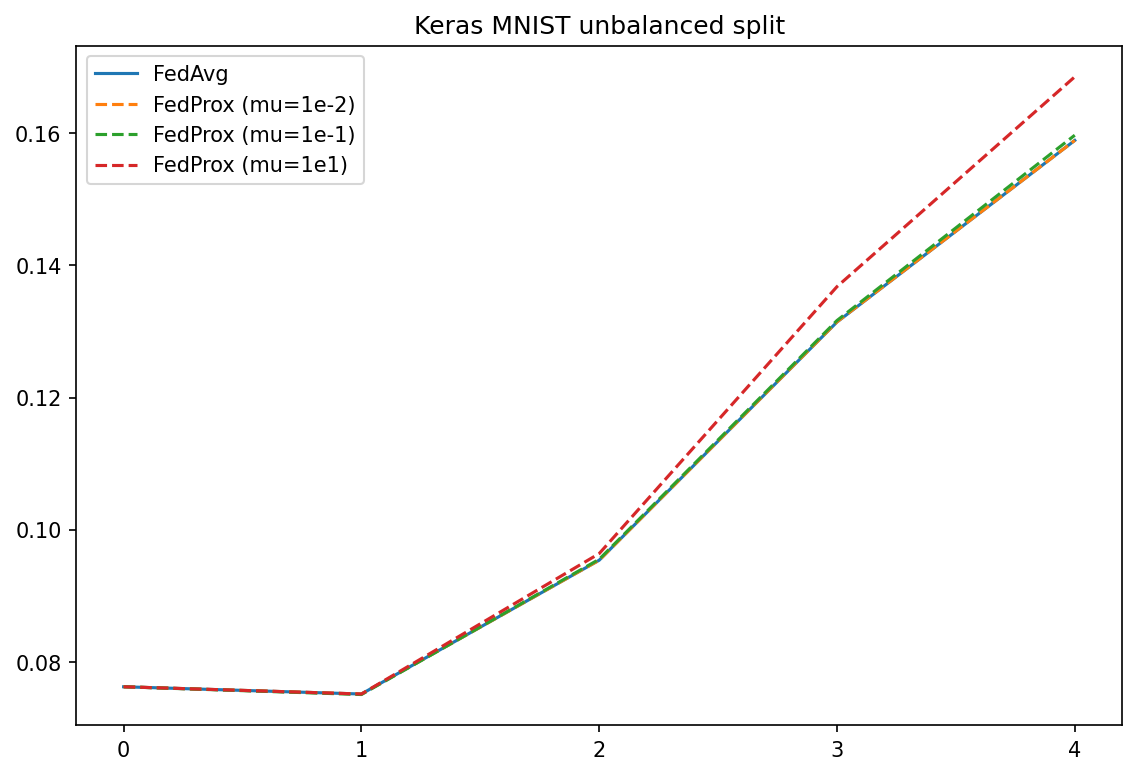

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,6), dpi=150)
plt.title('Keras MNIST unbalanced split')
plt.plot([0.07627802075538784, 0.07518334008473902, 0.09541350667830556, 0.13141966053564103, 0.15887578643299638], label='FedAvg')
plt.plot([0.07627802075538784, 0.07518334008473902, 0.09541350667830556, 0.1314459763141349, 0.15887578643299638], linestyle='--', label='FedProx (mu=1e-2)')
plt.plot([0.07627802075538784, 0.0751056043850258, 0.09555227747093886, 0.131649036151357, 0.15966261748969554], linestyle='--', label='FedProx (mu=1e-1)')
plt.plot([0.07627802075538784, 0.07517912408802659, 0.09641592293512076, 0.13676991989742965, 0.1684917744528502], linestyle='--', label='FedProx (mu=1e1)')

plt.legend()
plt.xticks(range(5))
plt.show()